# Random Input

In [1]:
from functools import partial
import pandas as pd
from qiskit.quantum_info import random_statevector

from utils import *
from spin_ham import *
from bounds import *
from trotter import *
from fermion_ham import *
import random

figs_dir, data_dir = './figs', './data'

## Power-law interaction Heisenberg Hamiltonian

In [3]:
## Check the power-law Hamiltonian and grouping
pow_test = Power_law(5, alpha=4, Jx=-1, Jy=-1, Jz=-1, hx=0.0, hy=0.0, hz=-0.5, pbc=False, verbose=False)
pow_test.ham
pow_test.ham_xyz
# commutator(pow_test.ham_xyz[0], pow_test.ham_xyz[1]).simplify()

[SparsePauliOp(['IIIXX', 'IIXIX', 'IXIIX', 'XIIIX', 'IIXXI', 'IXIXI', 'XIIXI', 'IXXII', 'XIXII', 'XXIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIYY', 'IIYIY', 'IYIIY', 'YIIIY', 'IIYYI', 'IYIYI', 'YIIYI', 'IYYII', 'YIYII', 'YYIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j]),
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII', 'IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII'],
               coeffs=[-1.      +0.j, -0.0625  +0.j, -0.012346+0.j, -0.003906+0.j, -1.      +0.j,
  -0.0625  +0.j, -0.012346+0.j, -1.      +0.j, -0.0625  +0.j, -1.      +0.j,
  -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j, -0.5     +0.j])]

In [4]:
prefix, suffix = 'Pow', 'n'
n_max = 10 
r = 10000 # 5000
eps = 1e-3
n_sample, n_round = 50, 10
m_sample = n_sample * n_round
n_list = np.arange(5, n_max+1)

In [5]:
data_keys = ['emp_worst', 'emp_averg', 'emp_averg_std', 'emp_averg_magn', 'emp_averg_corr', 'emp_averg_magn_std', 'emp_averg_corr_std', 'bnd_worst', 'bnd_averg', 'bnd_averg_magn', 'bnd_averg_corr', 'n']
data = dict([(k, []) for k in data_keys])
data['n'] = n_list

for n in n_list:
    print(f'------ n = {n} ------')
    pow_law = Power_law(n, alpha=4, Jx=-1, Jy=-1, Jz=-1, hx=-0.5, hy=0.0, hz=-0.0, pbc=False, verbose=False)
    # print('xyz group: ', pow_law.ham_xyz)
    # norm4 = nested_commutator_4norm([pow_law.ham_xyz[0], pow_law.ham_xyz[2]], p=2)
    # print('eeee:', norm4)
    # norm4_list.append(norm4)
    t = n
    corr_op = SparsePauliOp.from_sparse_list([('ZZ', [i,i+1], 1) for i in range(0, n-1)], n).to_matrix()
    magn_op = SparsePauliOp.from_sparse_list([('Z', [i], 1) for i in range(0, n)], n).to_matrix()
    # xyz_group = [h.to_matrix() for h in pow_law.ham_xyz]
    xyz_group = [h.to_matrix(True) for h in pow_law.ham_xyz]
    # rand_states = [random_statevector(2**n) for _ in range(n_sample)]
    # print(rand_states)
    exact_U = scipy.linalg.expm(-1j * t * sum([h.to_matrix() for h in pow_law.ham_xyz]))

    data['emp_worst'].append(n * measure_error(r, xyz_group, t, exact_U, 'worst_empirical'))
    data['bnd_worst'].append(n * measure_error(r, xyz_group, t, exact_U, 'worst_bound'))
    data['bnd_averg'].append(n * measure_error(r, xyz_group, t, exact_U, 'average_bound'))
    data['bnd_averg_magn'].append(measure_error(r, xyz_group, t, exact_U, 'average_ob_bound', ob=[magn_op]))
    # data['bnd_averg_magn_nc'].append(measure_error(r, xyz_group, t, exact_U, 'average_ob_bound_nc', ob=magn_op))
    data['bnd_averg_corr'].append(measure_error(r, xyz_group, t, exact_U, 'average_ob_bound', ob=[corr_op]))

    magn_list, corr_list, stat_list = [], [], []
    print('----empirical observable error----')
    rand_states = [random_statevector(2**n) for _ in range(m_sample)]
    stat_list = measure_error(r, xyz_group, t, exact_U, 'average_empirical', rand_states=rand_states, return_error_list=True, ob=magn_op)
    # stat_list = n * measure_error(r, xyz_group, t, exact_U, 'average_empirical', rand_states=rand_states, return_error_list=True)
    magn_list = measure_error(r, xyz_group, t, exact_U, 'average_ob_empirical', rand_states=rand_states, ob=magn_op, return_error_list=True)
    corr_list = measure_error(r, xyz_group, t, exact_U, 'average_ob_empirical', rand_states=rand_states, ob=corr_op, return_error_list=True)

    data['emp_averg'].append(np.mean(stat_list))
    data['emp_averg_magn'].append(np.mean(magn_list))
    data['emp_averg_corr'].append(np.mean(corr_list))
    data['emp_averg_std'].append(np.std(stat_list))
    data['emp_averg_magn_std'].append(np.std(magn_list))
    data['emp_averg_corr_std'].append(np.std(corr_list))
# save to csv
# print(pd.DataFrame(data))
# pd.DataFrame(data).to_csv(f'{data_dir}/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}_4norm.csv', index=False)
# save as npy
np.save(f'{data_dir}/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}_2norm.npy', data)

------ n = 5 ------
----empirical observable error----
------ n = 6 ------
----empirical observable error----
------ n = 7 ------
----empirical observable error----
------ n = 8 ------
----empirical observable error----
------ n = 9 ------
----empirical observable error----
------ n = 10 ------
----empirical observable error----


### Plot Error scaling vs n

a_em: 5.331419835554635; b_em: -17.104270889540626
a_em: 4.807628201395578; b_em: -17.086937423284063
a_em: 4.758605727965528; b_em: -18.954846750990175
a_em: 4.328439378300499; b_em: -17.4799516015155
a_em: 0.9230667137256244; b_em: -16.15558388051786


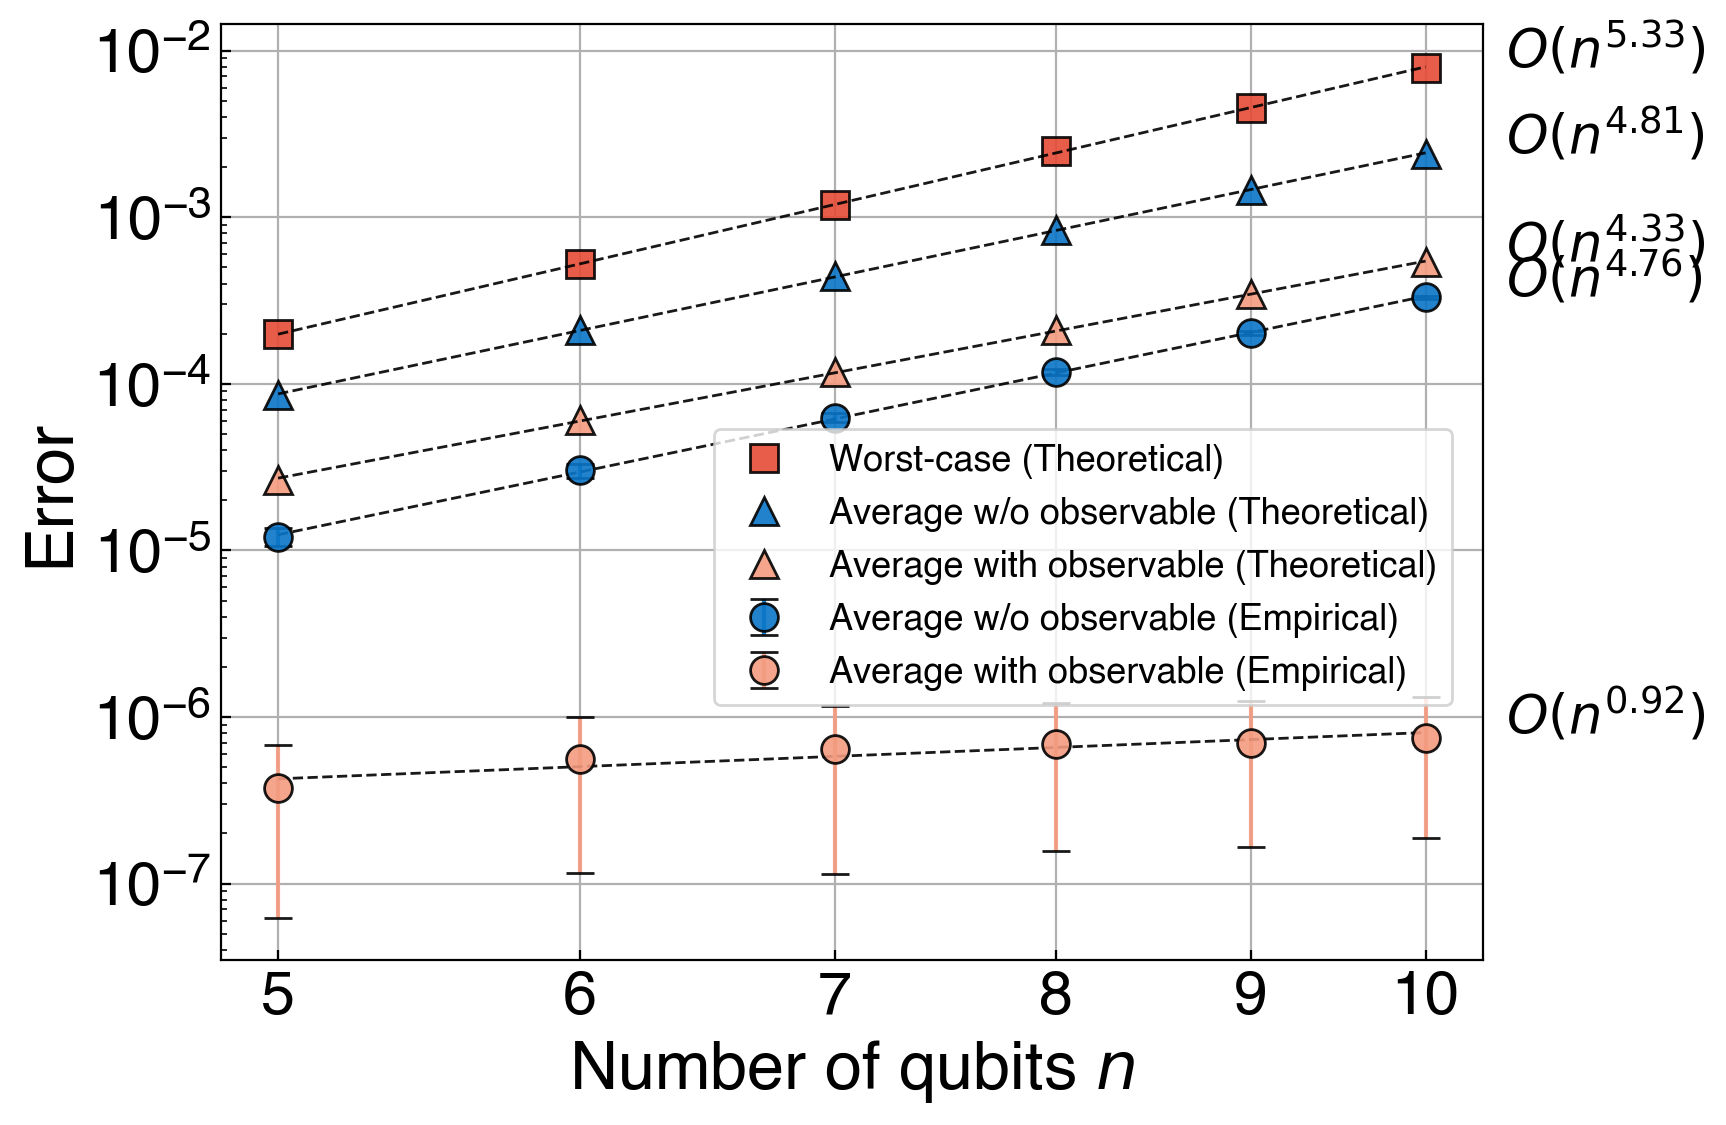

In [6]:
# pd.DataFrame(data).to_csv(f'{data_dir}/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv', index=False)
prefix, suffix = 'Pow', 'n'
n_max = 10
r = 10000 # 5000
eps = 1e-3
n_sample, n_round = 50, 10
n_list = np.arange(5, n_max+1)
# read from csv
# data = pd.read_csv(f'{data_dir}/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}.csv')
# read from npy
data = np.load(f'{data_dir}/{prefix}_data_max={n_max}_sample={n_sample}_{suffix}_2norm.npy', allow_pickle=True).item()

# # plot results
plt.rc('legend', fontsize=MEDIUM_SIZE-2) 
fig, ax = plt.subplots(1, 1, figsize=(9, 6), layout='tight')
# ax.plot(n_list, norm4_list, 's', label='Norm4')
ax.plot(n_list, data['bnd_worst'], 's', label='Worst-case (Theoretical)', color="#E64B35FF")
ax.plot(n_list, data['bnd_averg'], '^', label='Average w/o observable (Theoretical)', color="#0A75C7")
ax.plot(n_list, data['bnd_averg_magn'], '^', label='Average with observable (Theoretical)', color="#F39B7FFF")
# ax.plot(n_list, data['emp_worst'], 'D', label='Worst-case (Empirical)', color="#E64B35FF")
ax.errorbar(n_list, data['emp_averg'], data['emp_averg_std'], fmt='o', label='Average w/o observable (Empirical)', capsize=5, color="#0A75C7")
ax.errorbar(n_list, data['emp_averg_magn'], data['emp_averg_magn_std'], fmt='o', label='Average with observable (Empirical)', capsize=5, color="#F39B7FFF")

plot_fit(ax, n_list, data['bnd_worst'], var=suffix, x_offset=1.05)
# plot_fit(ax, n_list, data['emp_worst'], var=suffix, x_offset=1.05, y_offset=0.90)
plot_fit(ax, n_list, data['bnd_averg'], var=suffix, x_offset=1.05)
plot_fit(ax, n_list, data['emp_averg'], var=suffix, x_offset=1.05)
plot_fit(ax, n_list, data['bnd_averg_magn'], var=suffix, x_offset=1.05)
plot_fit(ax, n_list, data['emp_averg_magn'], var=suffix, x_offset=1.05)
ax.set_xlabel(rf'Number of qubits $n$')
ax.set_ylabel(rf'Error')
ax.loglog(); ax.grid()
ax.set_xticks(n_list)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.legend(loc='center right', bbox_to_anchor=(0.99, 0.42)) 
plt.rc('legend', fontsize=MEDIUM_SIZE-2) 
# ax.legend(loc='center right', bbox_to_anchor=(1.0, 0.32))
# fig.savefig(f'{figs_dir}/random_{prefix}_max={n_list[-1]}_{suffix}_sample={n_sample}_6lines.pdf', dpi=150, bbox_inches='tight')

## Chemical molecules (Hydrogen chain)

### Error VS time

In [3]:

# d_list = np.linspace(0.1, 2, 20)

test_H = hydrogen_chain_hamiltonian(3, 1.0, verbose=False)
# o_list = regroup_H(test_H)
o_list = test_H.h_group

norm_list = [four_norm(o) for o in o_list]
print(sum(norm_list))
print(np.linalg.norm(test_H.pstrs_coeff, ord=1))
print(four_norm(sum(o_list)))
print(sum(norm_list)/four_norm(sum(o_list)))
print(np.linalg.norm(test_H.pstrs_coeff, ord=1)/sum(norm_list))

# pstr: 62, ['IIIIII', 'ZIIIII', 'YZZZYI', 'XZZZXI', 'IZIIII', 'IYZZZY', 'IXZZZX', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZZIIII', 'YIZZYI', 'XIZZXI', 'YXXYII', 'YYXXII', 'XXYYII', 'XYYXII', 'ZYZZZY', 'ZXZZZX', 'YXIIXY', 'YYIIXX', 'XXIIYY', 'XYIIYX', 'ZIZIII', 'YZIZYI', 'XZIZXI', 'ZIIZII', 'YZZIYI', 'XZZIXI', 'YZYYZY', 'YZYXZX', 'XZXYZY', 'XZXXZX', 'ZIIIZI', 'ZIIIIZ', 'YZZZYZ', 'XZZZXZ', 'IZZIII', 'IYIZZY', 'IXIZZX', 'IYXXYI', 'IYYXXI', 'IXXYYI', 'IXYYXI', 'IZIZII', 'IYZIZY', 'IXZIZX', 'IZIIZI', 'IYZZIY', 'IXZZIX', 'IZIIIZ', 'IIZZII', 'IIYXXY', 'IIYYXX', 'IIXXYY', 'IIXYYX', 'IIZIZI', 'IIZIIZ', 'IIIZZI', 'IIIZIZ', 'IIIIZZ']
# groups 7
(1.51169996465782+0j)
4.04758188387494
(0.918486003675016+0j)
(1.6458606430683274+0j)
(2.677503458691373+0j)


### Prepare empirical and theoretical bound data 

In [2]:
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_ground_state, get_sparse_operator
from qiskit.quantum_info import random_statevector, Statevector, random_unitary

import jax, scipy

prefix, suffix = 'Chem', 't'
# dir = '../figs'

rand_type = 'haar' # '1'
d = 1.0
n_hydrogen = 3
n = n_hydrogen * 2
h2_init = hydrogen_chain_hamiltonian(n_hydrogen, 1, verbose=False)
# o_list_init = regroup_H(h2_init, verbose=False)
ob_list = h2_init.h_group
h2_finl = hydrogen_chain_hamiltonian(n_hydrogen, 2.0, verbose=False)
# o_list = regroup_H(h2_finl)
h_list = [h.to_matrix() for h in h2_finl.h_group]
assert np.linalg.norm(sum(h_list) - sum(h2_finl.hamiltonian_list), ord=2) < 1e-10

ground_state = Statevector.from_label('0'*n).data
# ground_state = random_statevector(2**(2*n_hydrogen)).data
init_st = ground_state.T
# print('init state: ', init_st)  
# r = 100
n_sample = 500
t_list = np.linspace(0.1, 15, 15)
# dt = 0.1
dt = 1/10

chem_keys = ['worst_err', 'averg_err', 'averg_err_std', 'typic_err', 'typic_err_trace', 'worst_ob_err', 'averg_ob_err', 'averg_ob_err_std', 'typic_ob_err','t']
chem_data = dict([(k, []) for k in chem_keys])
chem_data['t'] = t_list

# h_list = [h.to_matrix() for h in h_list]
print('----start empirical----')
for t in t_list:
    # print(f'------t: {t}-----')  
    print(f'+', end='')
    r = int(t/dt)
    # print("H norm: ", np.linalg.norm(sum([h for h in h2_init.hamiltonian_list]), ord=2) )
    exact_U = scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
    # h_list = h2_finl.qubit_terms
    # h_list = h2_finl.hamiltonian_list
    appro_U = pf_r(h_list, t, r, order=2, use_jax=False)
    # exact_U = jax.scipy.linalg.expm(-1j * t * sum([h  for h in h2_finl.hamiltonian_list]))
    # h_list = h2_finl.hamiltonian_list
    # appro_U = pf_r(h_list, t, r, order=2, use_jax=True)
    if rand_type == 'haar':
        rand_states = [random_statevector(len(exact_U)) for _ in range(n_sample)]
    elif rand_type == '1':
        rand_states = [Statevector(tensor_random_unitaries(n) @ Statevector.from_label('0'*n).data) for _ in range(n_sample)]
    else:
        raise ValueError('rand_type should be either haar or 1')

    # chem_data['worst_err'].append(2*np.linalg.norm(exact_U - appro_U, ord=2))
    # averg_st_err = [np.linalg.norm(np.outer(exact_U @ state.data.conj().T , (exact_U @ state.data.conj().T).conj().T) - np.outer(appro_U @ state.data.conj().T, (appro_U @ state.data.conj().T).conj().T), ord='nuc') for state in rand_states] 
    averg_st_err = measure_error(r, h_list, t, exact_U, 'average_empirical', rand_states=rand_states, ob=ob_list, return_error_list=True)
    # averg_st_err = [np.linalg.norm(exact_U @ state.data.conj().T - appro_U @ state.data.conj().T) for state in rand_states]
    # print(averg_ob_err)
    chem_data['averg_err'].append(np.mean(averg_st_err))
    chem_data['averg_err_std'].append(np.std(averg_st_err))
    exact_st = exact_U @ init_st
    appro_st = appro_U @ init_st

    averg_ob_err = measure_error(r, h_list, t, exact_U, type='average_ob_empirical', rand_states=rand_states, ob=ob_list, return_error_list=True)
    chem_data['averg_ob_err'].append(np.mean(averg_ob_err))
    chem_data['averg_ob_err_std'].append(np.std(averg_ob_err))

print('----end empirical----')

ob_norm = sum([np.linalg.norm(ob.to_matrix(), ord=2) for ob in ob_list])
ob_1norm = np.linalg.norm(h2_init.pstrs_coeff, ord=1)
# print('ob_norm: ', ob_norm)
print('ob_1norm: ', np.linalg.norm(h2_init.pstrs_coeff, ord=1))
# print('ob_2norm: ', np.linalg.norm(sum(ob_list), ord=2))
worst_st_err_bnd = 2 * ob_1norm * tight_bound(h_list, 2, 1, 1/dt, type='spectral')
averg_st_err_bnd = 2 * ob_1norm * tight_bound(h_list, 2, 1, 1/dt, type='fro')

onestep_exactU = scipy.linalg.expm(-1j * dt * sum([herm for herm in h_list]))
d = len(h_list[0])
E_op = onestep_exactU - pf_r(h_list, dt, 1, order=2, use_jax=False)

averg_ob_err_bnd = measure_error(1/dt, h_list, 1, onestep_exactU, 'average_ob_bound', ob=ob_list)

print(worst_st_err_bnd, averg_st_err_bnd, averg_ob_err_bnd)

# pstr: 62, ['IIIIII', 'ZIIIII', 'YZZZYI', 'XZZZXI', 'IZIIII', 'IYZZZY', 'IXZZZX', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZZIIII', 'YIZZYI', 'XIZZXI', 'YXXYII', 'YYXXII', 'XXYYII', 'XYYXII', 'ZYZZZY', 'ZXZZZX', 'YXIIXY', 'YYIIXX', 'XXIIYY', 'XYIIYX', 'ZIZIII', 'YZIZYI', 'XZIZXI', 'ZIIZII', 'YZZIYI', 'XZZIXI', 'YZYYZY', 'YZYXZX', 'XZXYZY', 'XZXXZX', 'ZIIIZI', 'ZIIIIZ', 'YZZZYZ', 'XZZZXZ', 'IZZIII', 'IYIZZY', 'IXIZZX', 'IYXXYI', 'IYYXXI', 'IXXYYI', 'IXYYXI', 'IZIZII', 'IYZIZY', 'IXZIZX', 'IZIIZI', 'IYZZIY', 'IXZZIX', 'IZIIIZ', 'IIZZII', 'IIYXXY', 'IIYYXX', 'IIXXYY', 'IIXYYX', 'IIZIZI', 'IIZIIZ', 'IIIZZI', 'IIIZIZ', 'IIIIZZ']
# groups 7
# pstr: 62, ['IIIIII', 'ZIIIII', 'YZZZYI', 'XZZZXI', 'IZIIII', 'IYZZZY', 'IXZZZX', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ', 'ZZIIII', 'YIZZYI', 'XIZZXI', 'YXXYII', 'YYXXII', 'XXYYII', 'XYYXII', 'ZYZZZY', 'ZXZZZX', 'YXIIXY', 'YYIIXX', 'XXIIYY', 'XYIIYX', 'ZIZIII', 'YZIZYI', 'XZIZXI', 'ZIIZII', 'YZZIYI', 'XZZIXI', 'YZYYZY', 'YZYXZX', 'XZXYZY', 'XZXXZX', 'ZI

Text(18.0, 4.6624085505713694e-08, '')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


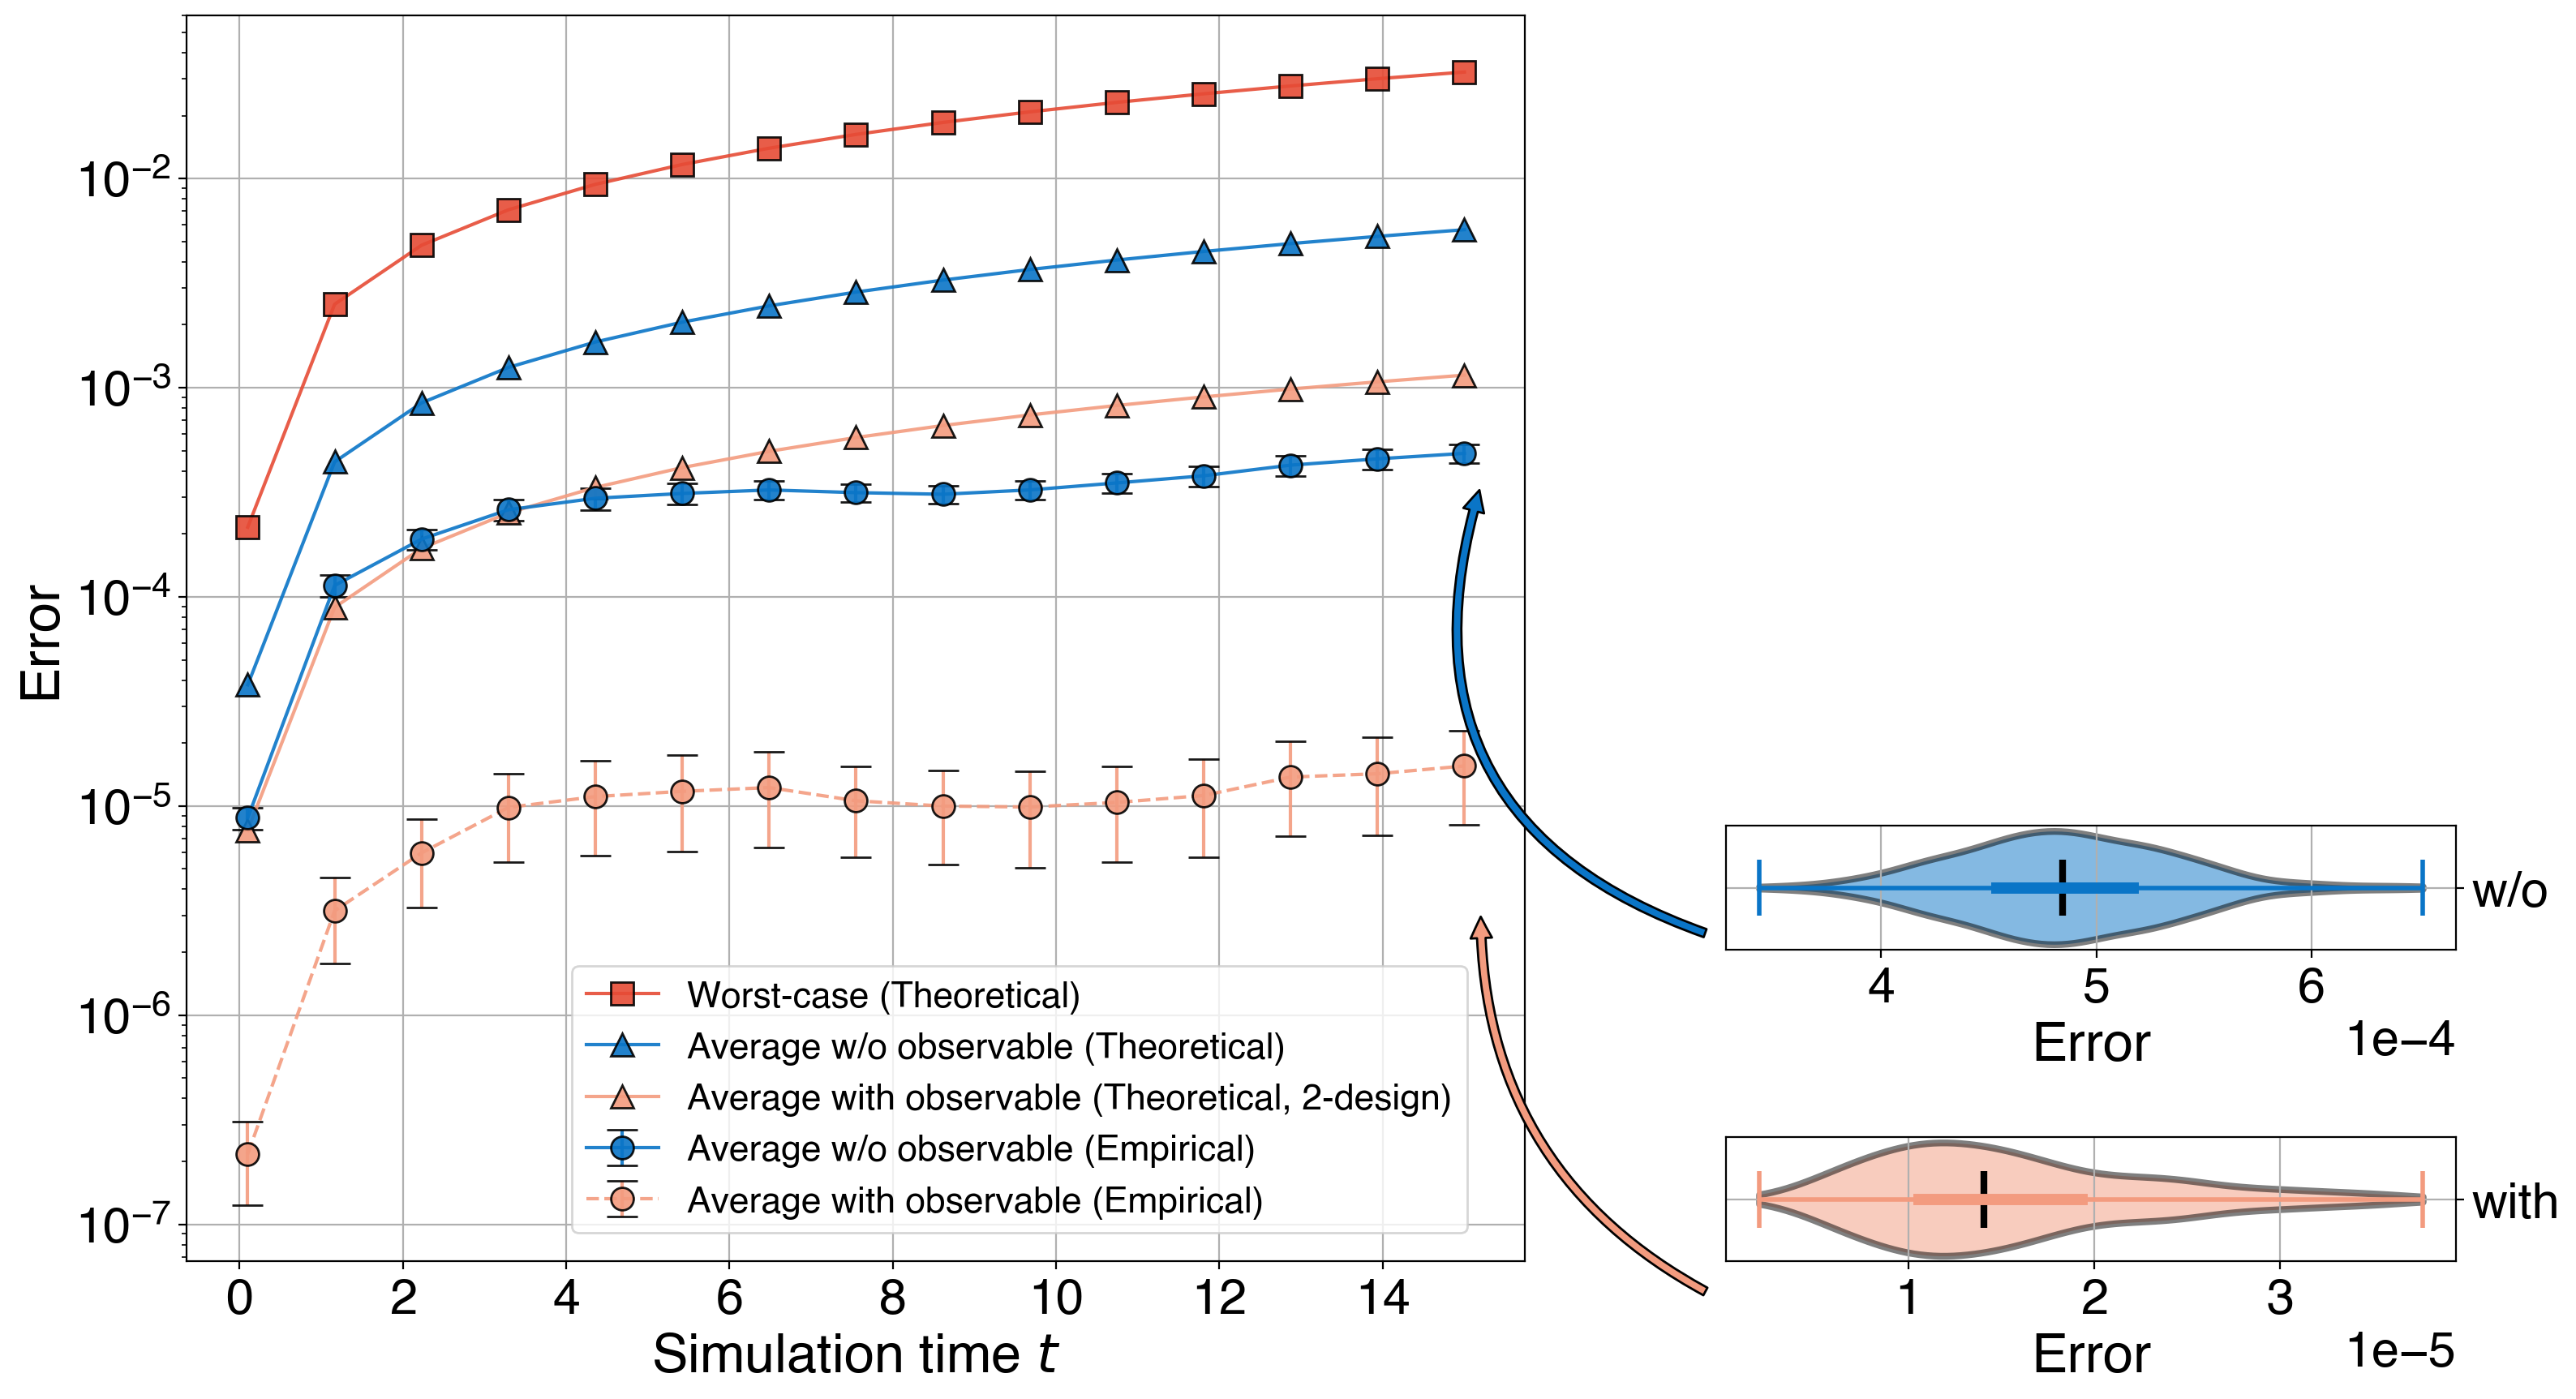

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(11, 9), layout='tight')
plt.rc('legend', fontsize=MEDIUM_SIZE+1)  
s = 1
# scale = 1.64
# scale = 1
# ax.plot(chem_data['t'][::s], chem_data['worst_err'][::s], 'D-', label='Worst-case (Empirical)', color='#E64B35FF')
ax.plot(chem_data['t'][::s], [worst_st_err_bnd*t*2 for t in chem_data['t'][::s]], 's-', label='Worst-case (Theoretical)', color='#E64B35FF')
# ax.plot(chem_data['t'], chem_data['typic_err'], 'o-', label='Specific-case (state, l2 norm)')
# ax.plot(chem_data['t'], chem_data['typic_err_trace'], 'o-', label='Specific-case (state, trace norm)')
# ax.plot(chem_data['t'], chem_data['typic_ob_err'], 'o--', label='Specific-case (observable)')

# ax.plot(chem_data['t'], chem_data['averg_err'], '^-', label='Average-case (state)')
# ax.plot(chem_data['t'], chem_data['averg_ob_err'], '^--', label='Average-case (observable)')
ax.errorbar(chem_data['t'][::s], chem_data['averg_err'][::s], chem_data['averg_err_std'][::s], fmt='o-', label='Average w/o observable (Empirical)', capsize=7, color='#0A75C7FF')
# ax.plot(chem_data['t'][::s], np.array(chem_data['worst_ob_err'][::s]), 's--', label='Worst-case (observable)')

ax.errorbar(chem_data['t'][::s], chem_data['averg_ob_err'][::s], chem_data['averg_ob_err_std'][::s], fmt='o--', label='Average with observable (Empirical)', capsize=7, color='#F39B7FFF')
ax.plot(chem_data['t'][::s], [averg_st_err_bnd*t for t in chem_data['t'][::s]], '^-', label='Average w/o observable (Theoretical)', color='#0A75C7FF')
# ax.plot(chem_data['t'][::s], scale*np.array([averg_ob_err_bnd*t for t in chem_data['t'][::s]]), '^-', label='Average with observable (Theoretical)', color='#F39B7FFF')
ax.plot(chem_data['t'][::s], np.array([averg_ob_err_bnd*t for t in chem_data['t'][::s]]), '^-', label='Average with observable (Theoretical, 2-design)', color='#F39B7FFF')
# ax.set_title(rf'H{n_hydrogen} chain, init d={d}, H=H{n_hydrogen}(2d), ob=H2(d), dt={0.1}')
# ax.set_title(rf'H{n_hydrogen} chain, init d={d}, H=H2(2d), ob=H2(d), r={r}')
ax.set_xlabel(rf'Simulation time $t$')
ax.set_ylabel(rf'Error')
ax.grid()
ax.set_yscale("log")   
# ax.loglog()
ax.legend(loc='center right', bbox_to_anchor=(0.97, 0.13))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# mpl.rcParams['legend.frameon'] = True
# ax_pow = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(-1.33, .0, 1.0, 1.0), bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins1 = inset_axes(ax, width=4.5, height="100%", bbox_to_anchor=(1.15, .0, .7, 0.1), bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins0 = inset_axes(ax, width=4.5, height="100%", bbox_to_anchor=(1.15, .25, .7, 0.1), bbox_transform=ax.transAxes, loc=2, borderpad=0)
# axins2 = inset_axes(ax, width=3.5, height="100%", bbox_to_anchor=(1.05, .5, .5, 0.5), bbox_transform=ax.transAxes, loc=2, borderpad=0)

# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axins1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axins1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axins0.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

violin_data0, violin_data1 = [averg_st_err], [averg_ob_err]
# violin_data = [[chem_data['worst_err'][-1]], averg_st_err, averg_ob_err]
# axins1.boxplot(violin_data)
vplots0 = axins0.violinplot(violin_data0, showmeans=False, showmedians=True, vert=False)
vplots1 = axins1.violinplot(violin_data1, showmeans=False, showmedians=True, vert=False)
# axins1.set_xticks([1,2], labels=['w/o', 'w/'])
axins1.set_yticks([1], labels=['with'])
axins0.set_yticks([1], labels=['w/o'])
# axins1.set_xlim([0-0.05*chem_data['worst_err'][-1], 1.05*chem_data['worst_err'][-1]])
# axins1.set_xticklabels(['w/o', 'w/'])
# axins1.set_yticks(2e-5 * np.array([0, 1, 2]))
axins0.set_xlabel(rf'Error')
axins1.set_xlabel(rf'Error')
axins1.yaxis.tick_right()
axins0.yaxis.tick_right()
# axins0.xaxis.tick_top()
# axins1.xaxis.tick_top()
# axins0.xaxis.set_label_position("top")

# axins1.set_xticks([1,2,3], labels=['Worst', 'state', 'ob'])
colors = ["#F39B7FFF", "#0A75C7"]
# colors = ["#E64B35FF", "#47B167", "#0A75C7"]
# colors = ["#0A75C7", "#F39B7FFF"]
# Set the color of the violin patches
for pc, color in zip(vplots0['bodies'], colors):
    pc.set_facecolor(["#0A75C7FF"])
    pc.set_edgecolor('k')
    pc.set_alpha(0.5)
    pc.set_linewidth(3.0)
for partname in ('cbars', 'cmins','cmaxes','cmedians'):
    vp = vplots1[partname]
    vp.set_edgecolor(colors)
    vp.set_linewidth(2.0)

for pc, color in zip(vplots1['bodies'], colors):
    pc.set_facecolor(["#F39B7FFF"])
    pc.set_edgecolor('k')
    pc.set_alpha(0.5)
    pc.set_linewidth(3.0)
for partname in ('cbars', 'cmins','cmaxes','cmedians'):
    vp = vplots1[partname]
    vp.set_edgecolor(colors)
    vp.set_linewidth(2.0)
    vp = vplots0[partname]
    vp.set_edgecolor(["#0A75C7FF"])
    vp.set_linewidth(2.0)
# vplots1['cmedians'].set_edgecolor('k')
vplots1['cmedians'].set_edgecolor('k')
vplots1['cmedians'].set_linewidth(3.0)
vplots0['cmedians'].set_edgecolor('k')
vplots0['cmedians'].set_linewidth(3.0)
quartile1, medians, quartile3 = np.percentile(violin_data1, [25, 50, 75], axis=1)
# quartile1, medians, quartile3 = np.percentile([averg_st_err, averg_ob_err], [25, 50, 75], axis=1)
# axins1.hlines([1, 2], quartile1, quartile3, color=colors, linestyle='-', lw=5)
axins1.hlines([1], quartile1, quartile3, color=colors[0], linestyle='-', lw=5)
quartile1, medians, quartile3 = np.percentile(violin_data0, [25, 50, 75], axis=1)
axins0.hlines([1], quartile1, quartile3, color=colors[1], linestyle='-', lw=5)
# axins1.set_ylim([0-0.05*chem_data['worst_err'][-1], 1.05*chem_data['worst_err'][-1]])
axins1.grid();axins0.grid()
# axins1.vlines([2, 3], quartile1, quartile3, color=colors[1:], linestyle='-', lw=5)
ax.annotate('', (chem_data['t'][-1]+.2, chem_data['averg_err'][-1]*0.7), (chem_data['t'][-1]+3, chem_data['averg_err'][-1]*0.005), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3, rad=-0.48",facecolor=colors[1], lw=1))
ax.annotate('', (chem_data['t'][-1]+.2, chem_data['averg_ob_err'][-1]*0.2), (chem_data['t'][-1]+3, chem_data['averg_ob_err'][-1]*0.003), arrowprops=dict(arrowstyle="simple", connectionstyle="arc3, rad=-0.3",facecolor=colors[0], lw=1))
# fig.savefig(f'{figs_dir}/n={n_hydrogen}_{suffix}.pdf', dpi=150, bbox_inches='tight')

### Barplot: Fix error (search r)

----binary search r (r_start=1, r_end=100)----
the initial r_end is too small, increase it by 10 times.
the initial r_end is too small, increase it by 10 times.
the initial r_end is too small, increase it by 10 times.
r_start: 1 ; r_end: 50000
r_start: 1 ; r_end: 25000
r_start: 12500 ; r_end: 25000
r_start: 12500 ; r_end: 18750
r_start: 15625 ; r_end: 18750
r_start: 17187 ; r_end: 18750
r_start: 17968 ; r_end: 18750
r_start: 17968 ; r_end: 18359
r_start: 18163 ; r_end: 18359
r_start: 18163 ; r_end: 18261
r_start: 18163 ; r_end: 18212
r_start: 18187 ; r_end: 18212
r_start: 18199 ; r_end: 18212
r_start: 18205 ; r_end: 18212
r_start: 18205 ; r_end: 18208
r_start: 18205 ; r_end: 18206
r: 18206 ; err:  9.998962980309981e-06
----binary search r (r_start=1, r_end=100)----
the initial r_end is too small, increase it by 10 times.
the initial r_end is too small, increase it by 10 times.
the initial r_end is too small, increase it by 10 times.
r_start: 1 ; r_end: 50000
r_start: 1 ; r_end: 25000
r

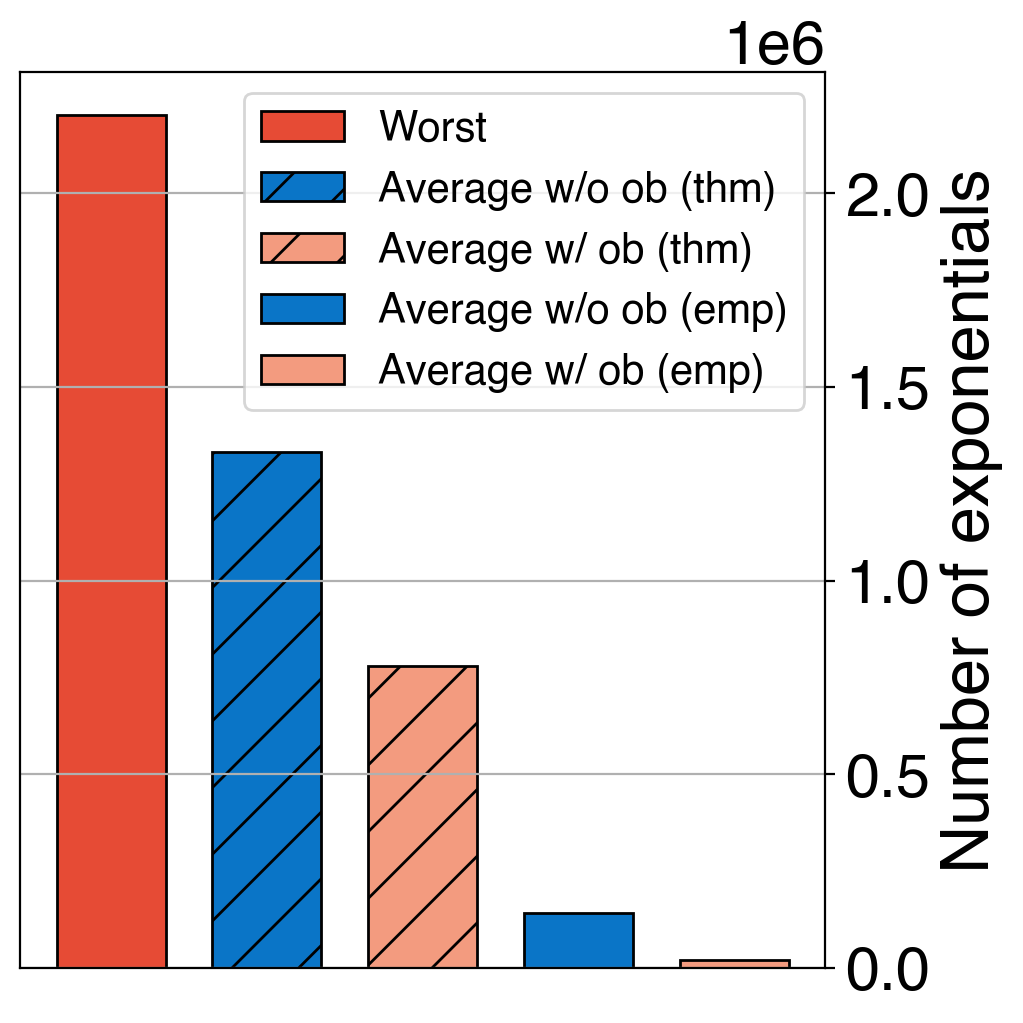

In [6]:
r_start, r_end = 1, 100
epsilon = 1e-5
t = 15
# t = 10
n_sample, n_round = 50, 50
exact_U = scipy.linalg.expm(-1j * t * sum([h for h in h2_finl.hamiltonian_list]))
bnd_worst_err_r = partial(measure_error, h_list=h_list, t=t, exact_U=None, type='worst_bound', coeffs=[h_ob_1norm])
bnd_averg_err_r = partial(measure_error, h_list=h_list, t=t, exact_U=None, type='average_bound', coeffs=[h_ob_1norm])
bnd_averg_ob_err_r = partial(measure_error, h_list=h_list, t=t, exact_U=None, ob=h_ob, type='average_ob_bound')

r_worst_bnd = binary_search_r(r_start, r_end, epsilon, bnd_worst_err_r, verbose=True)
r_averg_bnd = binary_search_r(r_start, r_end, epsilon, bnd_averg_err_r, verbose=True)
r_averg_ob_bnd = binary_search_r(r_start, r_end, epsilon, bnd_averg_ob_err_r, verbose=True)
print(f'r_worst_bnd={r_worst_bnd}, r_averg_bnd={r_averg_bnd}, r_averg_ob_bnd={r_averg_ob_bnd}')
r_averg_emp_list, r_averg_ob_emp_list = [], []
for round in range(n_round):
    print(f'========{round} round========')
    rand_states = [random_statevector(len(exact_U)) for _ in range(n_sample)]
    emp_averg_err_r = partial(measure_error, h_list=h_list, t=t, exact_U=exact_U, type='average_empirical', rand_states=rand_states, ob=h_ob)
    emp_averg_ob_err_r = partial(measure_error, h_list=h_list, t=t, exact_U=exact_U, ob=h_ob, type='average_ob_empirical', rand_states=rand_states)

    r_averg_emp = binary_search_r(r_start, r_end, epsilon, emp_averg_err_r, verbose=True)
    r_averg_ob_emp = binary_search_r(r_start, r_end, epsilon, emp_averg_ob_err_r, verbose=True)
    r_averg_emp_list.append(r_averg_emp)
    r_averg_ob_emp_list.append(r_averg_ob_emp)

L = (len(h_list) - 1) *2 - 1
print(L)
# ising1d = transverse_field_ising_1d(n, J, h, [1], verbose=verbose)
bar_data_12 = {
    'Worst': r_worst_bnd*L,
    'Average w/o ob (thm)': r_averg_bnd*L, # r=15 (LC), 569
    # 'Average w/o ob (emp)': r_averg_emp*L, # r=15 (LC), 569
    'Average w/o ob (emp)': np.mean(r_averg_emp_list)*L, # r=15 (LC), 569
    'Average w/ ob (thm)': r_averg_ob_bnd*L,
    # 'Average w/ ob (emp)': r_averg_ob_emp*L,
    'Average w/ ob (emp)': np.mean(r_averg_ob_emp_list)*L,
}
print(np.std(r_averg_emp_list), np.std(r_averg_ob_emp_list))
fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
colors = ["#E64B35FF", "#0A75C7FF", "#F39B7FFF", "#0A75C7FF", "#F39B7FFF"]

# for i, k in enumerate(bar_data_12.keys()):
#     ax.bar(k, bar_data_12[k], color=colors[i], label=k, width=0.7, edgecolor = "black")
ax.bar('Worst', bar_data_12['Worst'], color="#E64B35FF", label='Worst', width=0.7, edgecolor = "black")
ax.bar('Average w/o ob (thm)', bar_data_12['Average w/o ob (thm)'], color="#0A75C7FF", label='Average w/o ob (thm)', width=0.7, edgecolor = "black", hatch="/")
ax.bar('Average w/ ob (thm)', bar_data_12['Average w/ ob (thm)'], color="#F39B7FFF", label='Average w/ ob (thm)', width=0.7, edgecolor = "black", hatch="/")
ax.bar('Average w/o ob (emp)', bar_data_12['Average w/o ob (emp)'], color="#0A75C7FF", label='Average w/o ob (emp)', width=0.7, edgecolor = "black")
ax.errorbar('Average w/o ob (emp)', bar_data_12['Average w/o ob (emp)'], yerr=np.std(r_averg_emp_list)*L, color="k")
ax.bar('Average w/ ob (emp)', bar_data_12['Average w/ ob (emp)'], color="#F39B7FFF", label='Average w/ ob (emp)', width=0.7, edgecolor = "black")
ax.errorbar('Average w/ ob (emp)', bar_data_12['Average w/ ob (emp)'], yerr=np.std(r_averg_ob_emp_list)*L, color='k')

ax.set_xticks([])
# ax.set_yticks(data['Average w/ ob (thm)']*np.array(range(6)))
ax.legend()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylabel(f'Number of exponentials')
# ax.set_ylabel(f'Trotter steps  $r$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
# ax.set_xlabel('Observable')
ax.grid()